In [1]:
import pandas as pd

df = pd.read_parquet('./../parquet/dataset_site_info.parquet')

df = df.drop(columns=['dataset_id', 'replica_time_create', 'br_user_group_id'])
df = df.dropna()

for word in ['BUNNIES', 'Commissioning', 'RelVal', 'Parking']:
    df = df[~df['dataset_name'].str.contains(word)]

df = df[df['tier'] == 'RAW']

df.head(None)


,dataset_name,node_name,rep_size,min_time,max_time,tier
100,/ScoutingPFHT/Run2016H-v1/RAW,T1_US_FNAL_Disk,6.111641e+12,2019-06-14,2019-07-27,RAW
201,/ScoutingMonitor/Run2018C-v1/RAW,T2_AT_Vienna,1.082996e+13,2019-01-01,2019-02-25,RAW
215,/ScoutingMonitor/Run2018D-v1/RAW,T1_UK_RAL_Disk,4.391977e+13,2019-06-17,2019-06-18,RAW
632,/AlCaP0/Run2018D-v1/RAW,T1_US_FNAL_Disk,2.574883e+13,2019-08-29,2019-08-29,RAW
677,/AlCaPhiSym/Run2018C-v1/RAW,T2_FR_IPHC,2.956171e+12,2019-05-08,2019-05-08,RAW
...,...,...,...,...,...,...
6748400,/ZeroBias/Run2017F-v1/RAW,T2_US_Purdue,2.597084e+12,2019-04-12,2019-09-18,RAW
6748934,/ScoutingCaloMuon/Run2018D-v1/RAW,T1_US_FNAL_Disk,5.925237e+11,2019-03-26,2019-03-26,RAW
6749643,/EphemeralHLTPhysics4/Run2018D-v1/RAW,T2_CH_CERN,1.209395e+09,2019-05-18,2019-07-29,RAW
6752051,/SingleElectron/Run2016B-v2/RAW,T1_US_FNAL_Disk,1.675045e+12,2020-06-06,2020-12-31,RAW


In [2]:
sites = sorted(list(df['node_name'].unique()), reverse=True)
site_to_idx = {site: idx for idx, site in enumerate(sites)}


In [8]:
dataset_name = '/DoubleMuon/Run2018C-v1/RAW'
d_df = df[df['dataset_name'] == dataset_name]

max_size = d_df['rep_size'].max()


In [9]:
from datetime import date
from cmSim.utils import get_string_from_date

date_range = [dt.date() for dt in pd.date_range(
    date(2019, 1, 1), date(2020, 12, 31), freq='M')]
month_range = [get_string_from_date(date, format='%Y-%m')
                for date in date_range]
site_data = {site: {month: 0. for month in month_range}
             for site in sites}

for _, row in d_df.iterrows():
    site = row['node_name']
    for dt in pd.date_range(start=row['min_time'], end=row['max_time'], freq='M'):
        month = get_string_from_date(dt, format='%Y-%m')
        site_data[site][month] += row['rep_size']


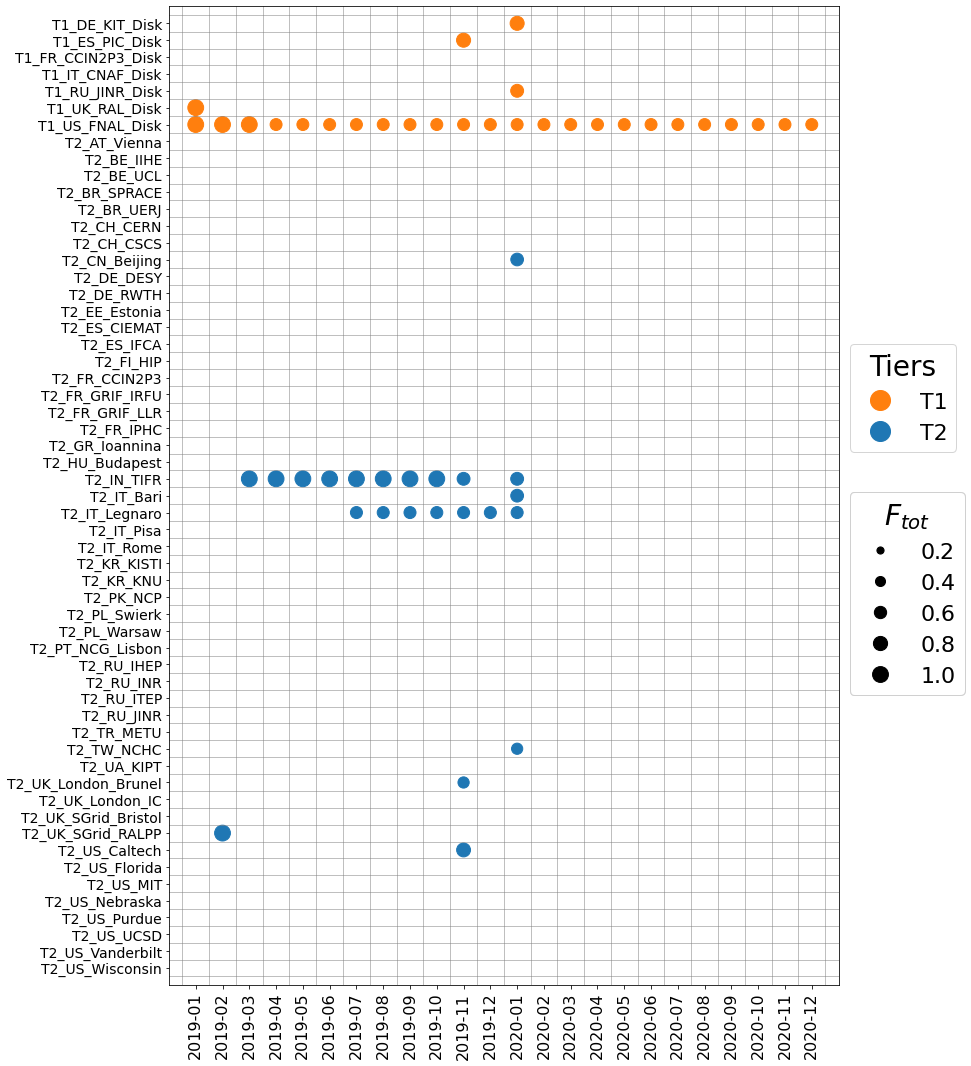

In [10]:
import pylab as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(12, 18))

ax.set_xlim(-1, len(month_range))
plt.xticks(range(len(month_range)), month_range, fontsize=16, rotation=90)
ax.set_ylim(-1, len(sites))
plt.yticks(range(len(sites)), sites, fontsize=14)

month_seq = []
site_seq = []
size_seq = []
color_seq = []
for site in site_data:
    for month in site_data[site]:
        fract = site_data[site][month] / max_size
        s = fract ** 0.25 * 250
        c = 'tab:orange' if site.startswith('T1_') else 'tab:blue'
        month_seq.append(month)
        site_seq.append(site)
        size_seq.append(s)
        color_seq.append(c)
scat = ax.scatter(month_seq, site_seq, s=size_seq, c=color_seq)
for x in range(len(month_range) + 1):
    ax.axvline(x - 0.5, color='grey', linewidth=0.5)
for y in range(len(sites) + 1):
    ax.axhline(y - 0.5, color='grey', linewidth=0.5)

orange_dot = mlines.Line2D([], [], color='tab:orange',
                           marker='.', markersize=40, linestyle='None', label='T1')
blue_dot = mlines.Line2D([], [], color='tab:blue', marker='.',
                         markersize=40, linestyle='None', label='T2')
leg1 = ax.legend(handles=[orange_dot, blue_dot],
                 title='Tiers', title_fontsize=28, fontsize=22,
                 loc='center left', bbox_to_anchor=(1, 0.1, 0.5, 1))

leg2 = plt.legend(*scat.legend_elements('sizes', num=6, func=lambda x: x / x.max()),
                  title='$F_{tot}$', title_fontsize=28, fontsize=22,
                  loc='center left', bbox_to_anchor=(1, -0.1, 0.5, 1))

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.show()
